A simple numerical method is the Lax-Friedrichs scheme where the numerical flux is defined as
\begin{equation}
    F^{\text{LF}}(u_L, u_R) = \frac{1}{2}(f(u_L) + f(u_R)) + \frac{1}{2} \frac{\Delta x}{\Delta t}(u_L - u_R).
\end{equation}

Another numerical method is the Richtmyer scheme. The numerical flux in this case is calculated via
\begin{equation}
    u^{\text{Ri}} = \frac{1}{2}(u_L + u_R) + \frac{1}{2}\frac{\Delta t}{\Delta x}(f(u_L) - f(u_R)), \quad F^{\text{Ri}}(u_L, u_R) = f(u^{\text{Ri}}).
\end{equation}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution(x, t):
    '''
    Calculates the exact analytical solution at a given time t.
    '''
    rarefaction_left = 1.0 - t
    rarefaction_right = 1.0 + 0.5 * t
    shock_pos = 2.0 + 0.25 * t

    return np.piecewise(x,
        [
            x < rarefaction_left,
            (x >= rarefaction_left) & (x <= rarefaction_right),
            (x > rarefaction_right) & (x < shock_pos),
            x >= shock_pos
        ],
        [
            -1.0,
            lambda x_in: (x_in - 1.0) / t, # Solution in rarefaction fan
            0.5,
            0.0
        ]
    )

In [ ]:
def physical_flux(u):
    '''
    Calculates the physical flux f(u) = 0.5 * u^2 for an array.
    '''
    return 0.5 * u**2

def lax_friedrichs_flux(uL, uR, dx, dt):
    '''
    Calculates the Lax-Friedrichs numerical flux F_LF for arrays of
    left and right states at the interfaces.
    '''
    fL = physical_flux(uL)
    fR = physical_flux(uR)
    return 0.5 * (fL + fR) - 0.5 * (dx / dt) * (uR - uL)

def richtmyer_flux(uL, uR, dx, dt):
    '''
    Calculates the Richtmyer numerical flux F^Ri.
    This is a two-step process as per equation (6).
    '''
    u_intermediate = 0.5 * (uL + uR) - 0.5 * (dt / dx) * (physical_flux(uR) - physical_flux(uL))
    return physical_flux(u_intermediate)

def set_initial_conditions(x):
    '''
    Sets the initial piecewise condition based on the spatial grid x.
    Returns a new array for the initial state u0.
    '''
    u0 = np.zeros_like(x)
    u0[x < 1.0] = -1.0
    u0[(x >= 1.0) & (x < 2.0)] = 0.5
    u0[x >= 2.0] = 0.0
    return u0

def apply_boundary_conditions(u):
    '''
    Applies out-flow boundary conditions.
    Returns a new array with boundary ghost cells updated.
    '''
    u_bc = u.copy()
    u_bc[0] = u_bc[1]   # Left boundary
    u_bc[-1] = u_bc[-2] # Right boundary
    return u_bc


In [ ]:
def advance_step(u, dx, dt, flux_function):
    '''
    Performs a single time step update using the Lax-Friedrichs scheme.
    Returns the solution at the next time level.
    '''
    u_bc = apply_boundary_conditions(u)
    uL = u_bc[:-1]
    uR = u_bc[1:]
    # Calculate fluxes at all interfaces
    fluxes = flux_function(uL, uR, dx, dt)
    u_next = u.copy()
    # Update the interior points using the conservative formula
    u_next[1:-1] = u[1:-1] - (dt / dx) * (fluxes[1:] - fluxes[:-1])

    return u_next

def solve(x, u0, t_final, cfl, flux_function):
    '''
    Main solver function that marches the solution forward in time.
    '''
    dx = x[1] - x[0]
    t = 0.0
    u = u0.copy()

    while t < t_final:
        # Calculate dynamic time step based on the current state
        max_speed = np.max(np.abs(u))
        dt = cfl * dx / max_speed if max_speed > 0 else 1e-4
        # Ensure the final time is not overshot
        dt = min(dt, t_final - t)
        # Get the solution at the next time step
        u = advance_step(u, dx, dt, flux_function)
        t += dt
    return u

def plot_results(x, u_initial, u_numerical, t_final):
    '''
    Generates a plot comparing the numerical and exact solutions.
    '''
    u_exact = analytical_solution(x, t_final)

    plt.figure(figsize=(8, 5))
    plt.title(f'Lax-Friedrichs Solution vs. Exact Solution at $t = {t_final}$')
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u(x, t)$')

    plt.plot(x, u_initial, 'k--', label='Initial Condition (t=0)')
    plt.plot(x, u_numerical, 'b-o', markersize=4, label='Numerical Solution')
    plt.plot(x, u_exact, 'r-', linewidth=2.5, label='Exact Solution')

    plt.grid(True)
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(-1.1, 0.6)
    plt.legend()
    plt.show()

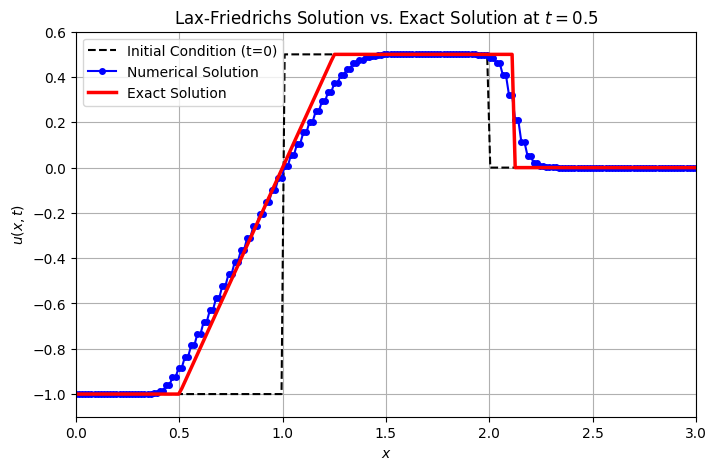

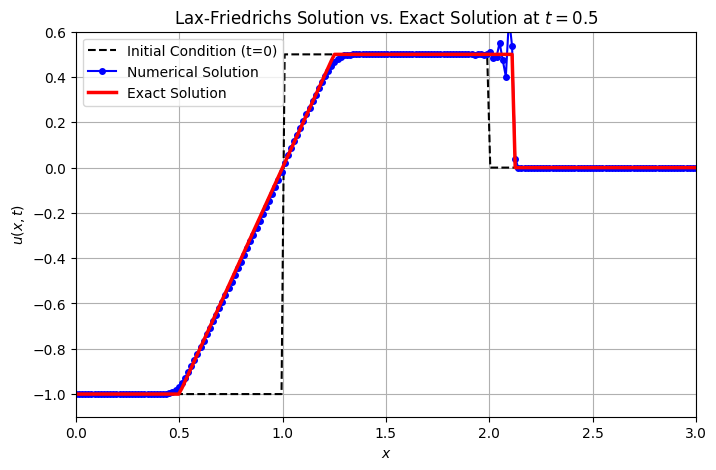

In [ ]:
# Parameters
J = 200
x_min, x_max = 0.0, 3.0
t_final = 0.5
cfl = 0.8

x = np.linspace(x_min, x_max, J)
u0 = set_initial_conditions(x)
u_final_lff = solve(x, u0, t_final, cfl, lax_friedrichs_flux)
plot_results(x, u0, u_final_lff, t_final)

u_final_rff = solve(x, u0, t_final, cfl, richtmyer_flux)
plot_results(x, u0, u_final_rff, t_final)

*   The numerical solution captures the overall shape and position of the evolved
wave profile quite well. The rarefaction fan and the shock wave are in the correct locations.

*   The most prominent feature of the Lax-Friedrichs scheme is its high level of numerical diffusion (or viscosity). This is clearly visible as a "smearing" of the sharp features of the exact solution. The corners at the beginning and end of the rarefaction wave are rounded off in the numerical solution. The shock wave, which should be a sharp discontinuity, is spread over several grid cells.

*   Despite the smearing, the scheme correctly propagates the wave features. The center of the numerical shock is very close to the analytical shock position of $x = 2.125$, and the slope of the numerical rarefaction wave closely matches the analytical one.

*   The Lax-Friedrichs scheme is first-order accurate in both time and space, which can be shown by a Taylor expasion and examining the leading order terms of the truncation error. This is a relatively low order of accuracy, and it is directly related to the high level of numerical diffusion observed in the results.

*   The Richtmyer scheme captures the rarefaction wave and the shock with generally good accuracy. However, it exhibits some oscillations around the discontinuities. The slope of the rarefaction fan is reasonably close to the analytical solution, but there are noticeable oscillations, especially at the edges of the fan.

*   The shock wave contains oscillations both ahead of and behind the shock. These oscillations are characteristic of higher-order schemes that attempt to represent discontinuities more sharply. The location of the shock is captured fairly accurately.

*   The main disadvantage of Richtmyer is its dispersive nature. Dispersion is the phenomenon where different frequencies of a wave propagate at different speeds, leading to oscillations around sharp gradients in the solution.

*   The Richtmyer scheme is second order accurate in both space and time within smooth regions of the flow. This manifests as a better representation of the rarefaction wave.

*A numerical scheme is said to be monotone if it preserves the monotonicity of the solution.*

The Lax-Friedrichs scheme is a monotone scheme. This means that if you start with a monotonically increasing or decreasing initial condition, the Lax-Friedrichs scheme will guarantee that the solution remains monotone at later times. This property is desirable for stability, but it comes at the cost of high numerical diffusion. The diffusion acts to smooth out any sharp gradients, preventing the formation of oscillations, but also blurring the solution.

The Richtmyer scheme is not monotone. The higher-order accuracy of the scheme comes at the cost of being unable to guarantee monotonicity. This lack of monotonicity is the direct cause of the oscillations observed near discontinuities (the Gibbs phenomenon).

There is a fundamental trade-off between accuracy and monotonicity in numerical methods for conservation laws. Godunov's theorem states that linear schemes of order higher than one cannot be monotone. This means that to achieve higher-order accuracy without oscillations, one must resort to non-linear schemes like TVD (total variation diminishing) or ENO (essentially non-oscillatory) schemes.

In summary, the Lax-Friedrichs scheme is very robust and stable, but it is overly diffusive. The Richtmyer scheme is more accurate in smooth regions but introduces oscillations due to its lack of monotonicity. More advanced schemes (TVD, ENO) try to strike a balance between accuracy and stability by being non-linear and adaptive, reducing oscillations while maintaining higher-order accuracy.